
--- KDE uniformity (m_check=20, bw=0.065) ---
               Point │  Estimate │     Error
--------------------------------------------------
[0.314 0.36  0.201] │    3.0013 │    0.0013
[0.655 0.623 0.196] │    3.0068 │    0.0068
[0.48  0.509 0.345] │    3.0068 │    0.0068
[0.534 0.601 0.271] │    2.9974 │   -0.0026
[0.684 0.57  0.2  ] │    2.9954 │   -0.0046
[0.454 0.435 0.302] │    2.9978 │   -0.0022
[0.57  0.603 0.352] │    2.9837 │   -0.0163
[0.415 0.552 0.319] │    2.9971 │   -0.0029
[0.474 0.508 0.305] │    2.9871 │   -0.0129
[0.389 0.6   0.35 ] │    2.9995 │   -0.0005
[0.354 0.649 0.299] │    3.0058 │    0.0058
[0.538 0.478 0.353] │    3.0104 │    0.0104
[0.509 0.512 0.419] │    2.9907 │   -0.0093
[0.329 0.537 0.224] │    3.0098 │    0.0098
[0.525 0.474 0.222] │    3.0090 │    0.0090
[0.63  0.36  0.296] │    3.0205 │    0.0205
[0.677 0.381 0.204] │    3.0106 │    0.0106
[0.444 0.451 0.452] │    3.0110 │    0.0110
[0.355 0.492 0.274] │    2.9845 │   -0.0155
[0.529 0.469 0.548] │

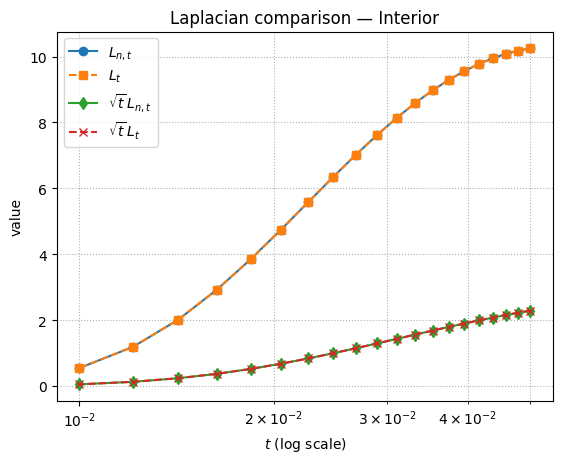

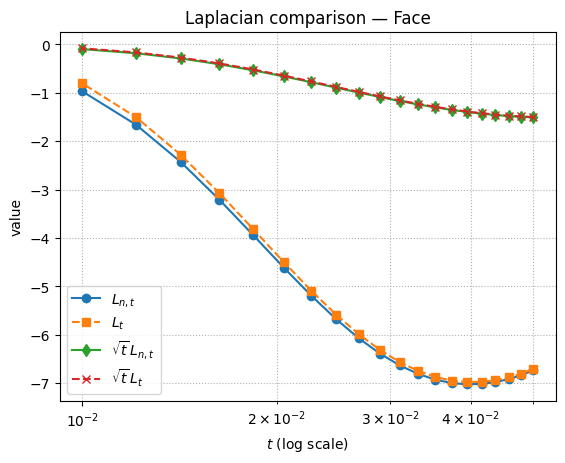

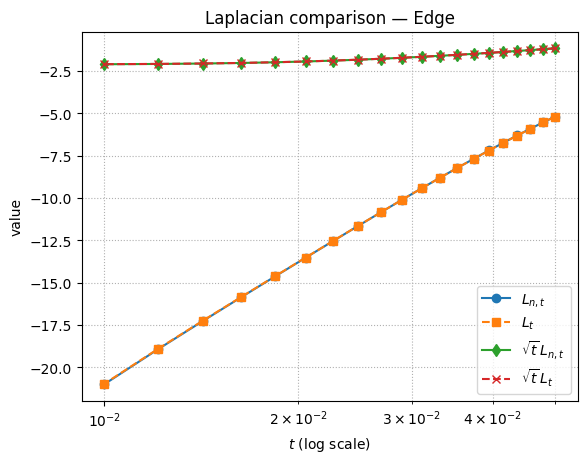

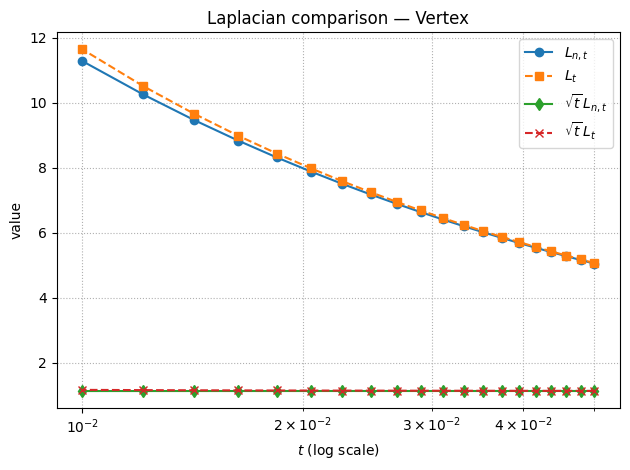

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# -------------------------------------------------------------------- #
# PARAMETERS
# -------------------------------------------------------------------- #
np.random.seed(42)
n_samples = 100_000_000
t_values  = np.linspace(0.05, 0.01, 20)
d         = 3

# -------------------------------------------------------------------- #
# 1 · Sample uniformly in the square-base pyramid
# -------------------------------------------------------------------- #
def sample_uniform_pyramid(n):
    u = np.random.rand(n)
    z = 1.0 - u**(1.0/3.0)
    v = np.random.rand(n)
    w = np.random.rand(n)
    scale = 1.0 - z
    x = 0.5 + (v - 0.5) * scale
    y = 0.5 + (w - 0.5) * scale
    return np.stack((x, y, z), axis=1)

X = sample_uniform_pyramid(n_samples)

# -------------------------------------------------------------------- #
# 2 · KDE Uniformity Check (20 random interior points)
# -------------------------------------------------------------------- #
def kde_uniformity(samples, m_check=20, bw_method=0.065):
    kde        = gaussian_kde(samples.T, bw_method=bw_method)
    candidates = sample_uniform_pyramid(1000)
    delta      = 3 * bw_method

    mask_z     = (candidates[:,2] > delta) & (candidates[:,2] < 1-delta)
    mask_xy    = np.abs(candidates[:,0] - 0.5) < (0.5*(1-candidates[:,2]) - delta)
    mask_xy   &= np.abs(candidates[:,1] - 0.5) < (0.5*(1-candidates[:,2]) - delta)
    mask       = mask_z & mask_xy
    interior   = candidates[mask]
    check      = interior[:m_check]

    est        = kde(check.T)
    true       = np.full_like(est, 3.0)       # True density = 3 for uniform pyramid
    err        = est - true

    fifty = 50
    print(f"\n--- KDE uniformity (m_check={len(check)}, bw={bw_method}) ---")
    print(f"{'Point':>20} │ {'Estimate':>9} │ {'Error':>9}")
    print("-" * fifty)
    for p, e, dv in zip(check, est, err):
        print(f"{np.round(p,3)} │ {e:9.4f} │ {dv:9.4f}")
    print("-" * fifty)
    print(f"Mean absolute error = {np.mean(np.abs(err)):.4f}\n")

# **Call the KDE check here**
kde_uniformity(X, m_check=20, bw_method=0.065)

# -------------------------------------------------------------------- #
# 3 · Define test function and Laplacians
# -------------------------------------------------------------------- #
def f(X):
    return np.sum(X, axis=1)

def discrete_graph_laplacian(f, x, X, t, d=3):
    diff    = f(x[None,:]) - f(X)
    weights = np.exp(-np.sum((x - X)**2, axis=1) / t)
    return np.sum(weights * diff) / (len(X) * t**(d/2 + 1))

def continuous_graph_laplacian_quadrature(f, x, t, d=3, m=30):
    coords = np.linspace(0,1,m,endpoint=False)+0.5/m
    grid_pts = []
    for xi in coords:
        for yi in coords:
            max_z = 1 - 2*max(abs(xi-0.5), abs(yi-0.5))
            if max_z > 0:
                zi_vals = coords[coords <= max_z]
                for zi in zi_vals:
                    grid_pts.append((xi, yi, zi))
    grid   = np.array(grid_pts)
    f_grid = f(grid)
    fx     = f(x[None,:])[0]
    sq     = np.sum((grid - x)**2, axis=1)
    K      = np.exp(-sq / t)
    return np.sum(K * (fx - f_grid)) / (grid.shape[0] * t**(d/2 + 1))

# -------------------------------------------------------------------- #
# 4 · Evaluation points in pyramid
# -------------------------------------------------------------------- #
eval_pts = {
    "Interior": np.array([0.5, 0.5, 0.5]),
    "Face"    : np.array([0.5, 0.5, 0.2]),
    "Edge"    : np.array([0.5, 0.25, 0.5]),
    "Vertex"  : np.array([0.5, 0.5, 1.0]),
}

# -------------------------------------------------------------------- #
# 5 · Build and print Laplacian table
# -------------------------------------------------------------------- #
rows = []
for t in t_values:
    row = {"t": t}
    for name, pt in eval_pts.items():
        Ln = (continuous_graph_laplacian_quadrature(f, pt, t, d)
              if name=="Interior"
              else discrete_graph_laplacian(f, pt, X, t, d))
        Lc = continuous_graph_laplacian_quadrature(f, pt, t, d)
        row[f"Ln_{name}"]     = Ln
        row[f"Lc_{name}"]     = Lc
        row[f"sqrtLn_{name}"] = np.sqrt(t) * Ln
        row[f"sqrtLc_{name}"] = np.sqrt(t) * Lc
    rows.append(row)

df = pd.DataFrame(rows)
pd.set_option("display.float_format", "{:.3e}".format)
print("\n--- Laplacian table ---")
print(df.to_string(index=False))

# -------------------------------------------------------------------- #
# 6 · Plot Laplacian comparisons
# -------------------------------------------------------------------- #
for name in eval_pts:
    plt.figure()
    plt.semilogx(df['t'], df[f"Ln_{name}"],      'o-',  label=r'$L_{n,t}$')
    plt.semilogx(df['t'], df[f"Lc_{name}"],      's--', label=r'$L_t$')
    plt.semilogx(df['t'], df[f"sqrtLn_{name}"], 'd-',  label=r'$\sqrt{t}\,L_{n,t}$')
    plt.semilogx(df['t'], df[f"sqrtLc_{name}"], 'x--', label=r'$\sqrt{t}\,L_t$')
    plt.xlabel('$t$ (log scale)')
    plt.ylabel('value')
    plt.title(f'Laplacian comparison — {name}')
    plt.legend()
    plt.grid(True, which='both', ls=':')
plt.tight_layout()
plt.show()
